In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import lsq_linear

from EightBitTransit.misc import calculateLCdecrements

In [2]:
#convenience methods duplicating what you did just to make sure I understand the geometry of what's going on

def symmetrize_opacity_map(opacity_map, cross_axis=0):
    """
    take averages across the horizontal line of symmetry
    returns a matrix of the same size as the opacity matrix
    """
    sym_opacity_map = 0.5 * (np.flip(opacity_map, axis=cross_axis) + opacity_map)
    return sym_opacity_map


def symmetrize_design_matrix(design_matrix, cross_axis=0):
    """
    combine contributions from different sides of the horizontal line of symmetry
    returns a matrix with length = ceil(original length / 2) along the cross-transit axis
    """
    if cross_axis != 0:
        design_matrix = np.swapaxes(design_matrix, 0, cross_axis)
    original_length = design_matrix.shape[0]
    sym_length = np.ceil(original_length / 2).astype(np.int) #full height of symmetrized design matrix
    reflected_length = np.floor(original_length / 2).astype(np.int) #height of part that gets reflected
    
    sym_design_matrix = (design_matrix[:sym_length] + 
                            design_matrix[-sym_length:][::-1])
    if (original_length % 2) == 1:
        #if there's a center row, it only contributes once
        sym_design_matrix[-1] *= 0.5
    
    if cross_axis != 0:
        sym_design_matrix = sym_design_matrix.swapaxes(sym_design_matrix, 0, cross_axis)
    
    return sym_design_matrix


def get_overlap_time_mask(times, N_rows, M_cols, v, t_ref):
    w = 2. / N_rows
    t_min = t_ref - (2. + w * M_cols)/(2. * v)
    t_max = t_ref + (2. + w * M_cols)/(2. * v)
    return (t_min < times) & (times < t_max)


def unfold_opacity_map(single_half_opacity_map):
    N_sym, M = single_half_opacity_map.shape
    N_full = 2 * N_sym - (N_sym % 2)
    full_opacity_map = np.zeros([N_full, M])
    full_opacity_map[:N_sym] = single_half_opacity_map
    full_opacity_map[-N_sym:] = np.flip(single_half_opacity_map, axis=0)
    return full_opacity_map



In [3]:
# Limb-darkening coefficients interpolated from Sing (2010):
LDlaw="quadratic"
LDCs = [0.2644, 0.3303]

data = np.genfromtxt("./boyajian_dip5_data.csv", delimiter=",")

times = data[:,0]
obs_LC = 1 - data[:,1]
obs_LC_err = data[:,2]

In [4]:
#mostly directly taken from examples notebook

test_vs = np.array((0.4,0.8,1.6,3.2))

t_ref=1.4405785
objective_function_vals = np.empty_like(test_vs)
solution_grids = []
best_LCs = []

for i in range(0, len(test_vs)):
    v = test_vs[i]
    print("v = {0}".format(v))
    
    # N chosen to be the highest possible integer value at each v, given that M is calculated from v (see below)
    # and that N * M cannot exceed the number of observed data points.
    if v < 1.0:
        N = 10
    elif v < 2.0:
        N = 7
    else:
        N = 5
    
    w = 2./N
    M = int(np.ceil((2.*(t_ref - np.min(times))*v - 2.)/w))

    test_times_mask = get_overlap_time_mask(times, N, M, v, t_ref)
    n_test_times = np.count_nonzero(test_times_mask)
    test_times = times[test_times_mask]
    test_LC = obs_LC[test_times_mask]
    
    try:
        decrement_test = np.load("./boyajianResults/boyajiansStar_dip5_LCdecs_v{0}_N{1}_M{2}.npy".format(v, N, M))
    except IOError:
        decrement_test = calculateLCdecrements(N=N,M=M,LDlaw=LDlaw, LDCs=LDCs, v=v, t_ref=t_ref, times=test_times)
        np.save("./boyajianResults/boyajiansStar_dip5_LCdecs_v{0}_N{1}_M{2}.npy".format(v, N, M), test_times)

    sym_N = np.ceil(N / 2).astype(np.int)
    sym_design_matrix = symmetrize_design_matrix(decrement_test).reshape([sym_N * M, len(times)]).T
    
    #
    #the new part:
    #
    out_bounded = lsq_linear(sym_design_matrix, test_LC, bounds=[0, 1])
    bounded_grid = unfold_opacity_map(out_bounded['x'].reshape([sym_N, M]))
    print(bounded_grid)
    
    if (v == 0.8):
        bounded_grid[:,0:6] = 0.
        
    if (v == 1.6):
        bounded_grid[:,0:12] = 0.
    
    if (v == 3.2):
        bounded_grid[:,0:20] = 0.
        
    if (v == 6.4):
        bounded_grid[:,0:42] = 0.
    
    best_LC = np.dot(sym_design_matrix, out_bounded['x'])
    best_LCs.append([test_times, best_LC])
    solution_grids.append(bounded_grid)
    objective_function_vals[i] = out_bounded['cost']
    

v = 0.4
[[4.86052794e-10 9.85175042e-10 4.72801320e-09 2.29020828e-09
  1.15127258e-12 7.10976304e-19 1.43785388e-02 1.27491010e-02
  5.17575649e-11 6.72047541e-15 6.67995113e-17 1.70710204e-19
  3.95799214e-19 3.25278974e-20 2.51990691e-21 1.44673628e-26
  1.00000000e+00 1.00000000e+00 7.06321626e-01 4.36808406e-21
  1.01269385e-20 4.47052126e-21 5.18813977e-20 3.52796223e-19
  1.13408068e-19 1.36163617e-18 5.79851119e-02 4.97886607e-02
  7.06455926e-26 1.07533062e-16 4.48487457e-14 1.34830617e-11
  1.10765732e-10 5.30046161e-11]
 [1.36263177e-09 2.25390058e-09 6.41780790e-10 1.07351859e-10
  5.80718622e-10 5.58425313e-03 4.72688829e-08 3.38385720e-12
  1.39483114e-14 3.60392690e-15 1.89310968e-16 1.90538954e-18
  1.09460900e-19 5.47518452e-20 6.35065298e-02 4.73645040e-25
  3.59434222e-21 7.84819618e-22 1.99317240e-22 1.22144816e-02
  1.68828745e-20 6.27455788e-21 5.17653760e-20 2.72826871e-19
  2.40130019e-23 1.85371998e-18 2.45959717e-17 1.29545282e-20
  1.21183620e-02 2.38663519e-

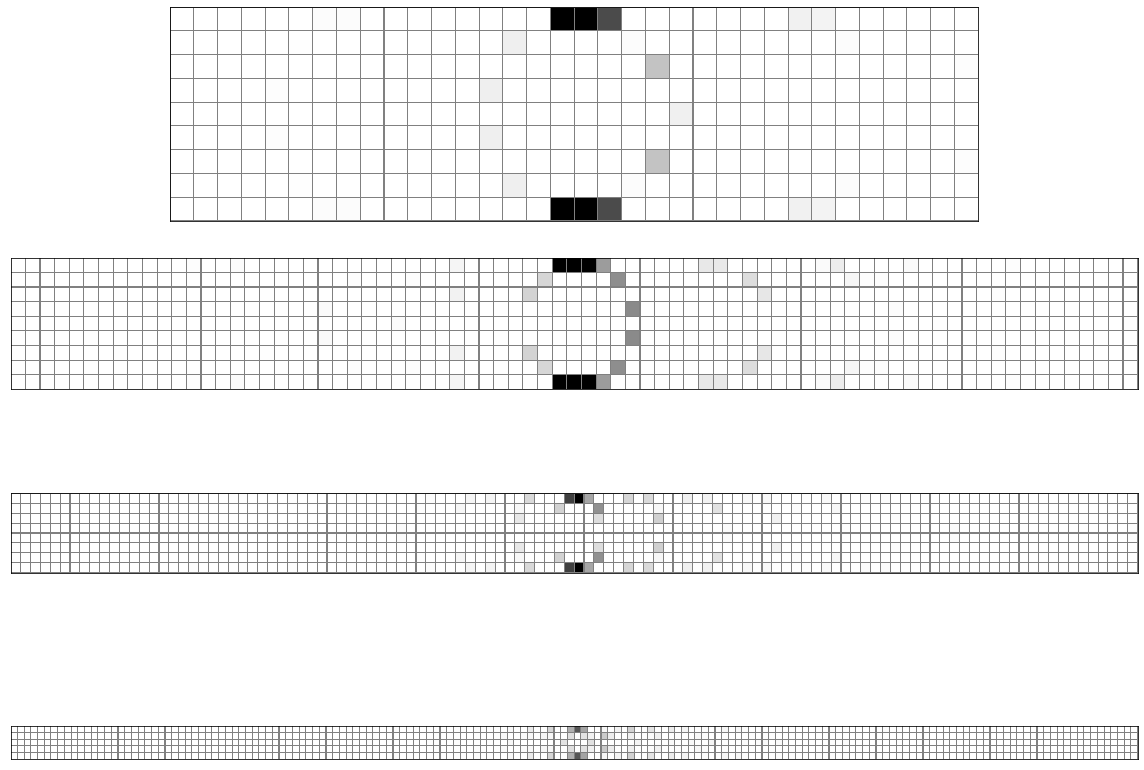

In [5]:
plt.figure(figsize=(16,3*len(test_vs)))

for i in range(len(test_vs)):
    ax = plt.subplot(len(test_vs), 1, i + 1, aspect='equal')
    plt.pcolormesh(solution_grids[i], vmin=0, vmax=1, cmap='gray_r', linewidth=0.1, edgecolor='gray')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
if False:
    plt.savefig('opacity_solutions.pdf')

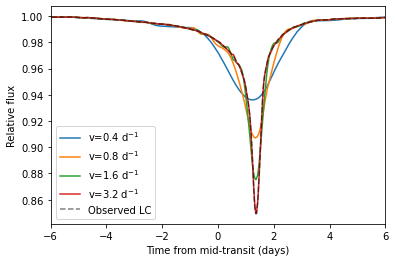

In [6]:
plt.figure()

for i in range(len(test_vs)):
    label = 'v=' + str(test_vs[i]) + ' d$^{-1}$'
    plt.plot(best_LCs[i][0], 1 - best_LCs[i][1], label=label)
plt.plot(times, 1 - obs_LC, color='black', linestyle='dashed', label='Observed LC',alpha=0.5);
plt.legend(loc='best')
plt.xlim(-6, 6)
plt.xlabel('Time from mid-transit (days)')
plt.ylabel('Relative flux')

if False:
    plt.savefig('LC_reconstruction.pdf')